In [95]:
import numpy as np
from qutip import *
from tqdm import tqdm
from multiprocessing import Pool
import matplotlib
from math import factorial
from matplotlib import pyplot as plt
from math import e
plt.rc('font', size=45)          # controls default text sizes
plt.rc('xtick', labelsize=40)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=30)    # fontsize of the tick labels
# plt.rc('legend', fontsize=20)    # legend fontsize
# plt.rc('lines', markersize = 10)

matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 16, 12
plt.rcParams['figure.dpi'] = 90
matplotlib.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid.which'] = "both"
props = dict(boxstyle='round', alpha=0.01)

In [2]:
def ham(J,K,h1,h2):
    sz = sigmaz()/2
    sx = sigmax()/2
    sy = sigmay()/2
    H = 0
    for ch in range(K):
        H += J*tensor([sx] + [identity(2)]*ch + [sx] + [identity(2)]*(K-ch-1))
        H += J*tensor([sy] + [identity(2)]*ch + [sy] + [identity(2)]*(K-ch-1))
        H += J*tensor([sz] + [identity(2)]*ch + [sz] + [identity(2)]*(K-ch-1))
        H += h2*tensor([identity(2)]*(1+ch) + [sz] + [identity(2)]*(K-ch-1))
    H += h1*tensor([sz] + [identity(2)]*K)
    return H

In [3]:
def get_Z(J,K,h,beta):
    h1,h2 = h
    H = ham(J,K,h1,h2)
    E = H.eigenenergies()
    Z = np.sum(np.exp(-beta*E))
    return Z


def get_chi_num(J,K,T_range,pos=0):
    delta = [np.array([1e-4, 0]), np.array([0, 1e-4]), np.array([1e-4, 1e-4])][pos]
    chi = []
    for T in T_range:
        beta = 1/T
        Z = get_Z(J,K,[0,0],beta)
        Z_plus_deltaZ = get_Z(J,K,delta,beta)
        Z_plus_2deltaZ = get_Z(J,K,2*delta,beta)
        dZdh = (Z_plus_deltaZ - Z)/sum(delta)
        d2Zdh2 = (Z_plus_2deltaZ + Z - 2*Z_plus_deltaZ)/(sum(delta)**2)
        chi.append(T * (d2Zdh2/Z - (dZdh/Z)**2))
        
    return chi

In [ ]:
def get_chi_exact(J,K,T_range):
    M_max = K/2
    M_min = 0 if K%2 == 0 else 1/2
    M_range = np.arange(M_min, M_max+0.1)
    C_M = np.array([factorial(K-1)/(factorial(int(K/2 - M))*factorial(int(K/2 - 1 + M))) for M in M_range])
    chi = []
    for T in T_range:
        beta = 1/T
        Z = np.sum(C_M * (4*np.exp(beta*J/4) * M_range * np.cosh(beta*J*(M_range+1/2)/2) + 2*np.exp(-beta*J*M_range/2)))
        Zpp = 0
        Sigma = np.array([np.sum((np.arange(-M, M-1+0.1) + 1/2)**2) for M in M_range])
        theta = (beta*J/2)*(M_range + 1/2)
        Zpp += (beta**2 / 2)*np.sum(C_M * np.exp(-beta*J*M_range/2))
        Zpp += (beta**2 * np.exp(beta*J/4) / 2) * np.sum(C_M * (2*M_range*np.sinh(theta) + (beta**2 * J**2 / 4)*Sigma*(np.cosh(theta)/theta - np.sinh(theta)/(theta**2)))/theta)
        chi.append(T * Zpp/Z)
        # print (Z, Zpp)
    return np.array(chi)


def get_chi_exact_bath(J, K, T_range):
    M_max = K/2
    M_min = 0 if K%2 == 0 else 1/2
    M_range = np.arange(M_min, M_max+0.1)
    C_M = np.array([factorial(K-1)/(factorial(int(K/2 - M))*factorial(int(K/2 - 1 + M))) for M in M_range])
    phi = J*(M_range + 1/2)/2
    chi = []
    for T in T_range:
        beta = 1/T
        Z_ex = np.sum(C_M * (2*np.exp(-beta*J*M_range/2) + 4*M_range*np.exp(beta*J/4)*np.cosh(beta*phi)))
        Sigma = []
        for M in M_range:
            m_range = np.arange(-M, M) if M != 0 else np.array([0])
            Sigma.append(np.sum((m_range+1/2)**2))
        Sigma = np.array(Sigma)
        Zpp_ex = (beta**2)*np.sum(C_M * 2*M_range**2 * np.exp(-beta*J*M_range/2))
        Zpp_ex += (beta**2)*2*np.exp(beta*J/4)*np.sum(C_M * Sigma*(1 + J**2/(16*phi**2))*np.cosh(beta*phi))
        Zpp_ex += (beta**2)*2*np.exp(beta*J/4)*np.sum(C_M * (Sigma*J*(1 - J/(16*beta*phi**2)) + M_range/beta)*np.sinh(beta*phi)/(2*phi))
        chi.append(Zpp_ex*T/Z_ex)
    
    return chi

In [ ]:
T_range = 10**np.linspace(-1.5, 0, 50)
K = 4
J = 1
cols = ['r', 'b', 'g', 'y']
for K in [1,2,4,6]:
    cols = [cols[-1]] + cols[:-1]
    J = 1/K
    chi_ex = get_chi_exact(J,K,T_range)
    chi_num = get_chi_num(J,K,T_range,pos=0)
    plt.scatter(T_range, chi_ex, marker='.', color=cols[-1], label=r"(analytical)$K={}$".format(K))
    plt.plot(T_range, chi_num, color=cols[-1], lw = 1, label=r"(numerical)$K={}$".format(K))

# # plt.plot(T_range, 1/T_range, ls="--")
plt.title(r"$J = 1/K$")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("$\chi_\mathrm{imp}$")
plt.xlabel(r"$T$")
plt.legend()
plt.savefig("chi_mchannel.pdf", bbox_inches='tight')
plt.show()

In [ ]:
K_range = np.int64(10**np.linspace(0,3,1000))
Sigma_max = np.array([np.sum((np.arange(-K/2, K/2-1+0.1) + 1/2)**2) for K in K_range])
plt.plot(K_range, Sigma_max/(K_range*(K_range+1)**2))
plt.axhline(1/12,0,1, ls="--")
plt.xscale("log")

In [ ]:
T_range = 10**np.linspace(-2.5, 2, 100)
K = 4
J = 2
cols = ['r', 'b', 'g', 'y']
for K in range(1,5):
    cols = [cols[-1]] + cols[:-1]
    J = 1/K
    chi_ex = get_chi_exact_bath(J,K,T_range)
    chi_num = get_chi_num(J,K,T_range, pos=1)
    plt.scatter(T_range, chi_ex, marker='.', color=cols[-1], label=r"(analytical)$K={}$".format(K))
    plt.plot(T_range, chi_num, color=cols[-1], lw = 2, label=r"(numerical)$K={}$".format(K))

plt.title(r"$J = 1/K$")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("$\chi_\mathrm{imp}$")
plt.xlabel(r"temperature")
plt.legend()
# plt.savefig("chi_mchannel.pdf", bbox_inches='tight')
plt.show()

In [ ]:
J = 1
cols = ['r', 'b', 'g', 'y']
for K in [1,2,5]:
    cols = [cols[-1]] + cols[:-1]
    hmin = -1
    hmax = -7
    for h in 10**np.linspace(hmin, hmax, 100):
        H = ham(J,K,h,h)
        E = H.eigenenergies()
        F1 = sum(E[E==min(E)])
        H = ham(J,K,h-h/10,h-h/10)
        E = H.eigenenergies()
        F2 = sum(E[E==min(E)])
        dFdh = (F2 - F1)/(-h/10)
        plt.scatter(h, dFdh, marker=".", color=cols[-1])
        H = ham(J,K,-h,-h)
        E = H.eigenenergies()
        F1 = sum(E[E==min(E)])
        H = ham(J,K,-h+h/10,-h+h/10)
        E = H.eigenenergies()
        F2 = sum(E[E==min(E)])
        dFdh = (F2 - F1)/(h/10)
        plt.scatter(-h, dFdh, marker=".", color=cols[-1])
    plt.scatter([], [], marker=".", color=cols[-1], label=r"$K={}$".format(K))

plt.legend()
plt.xlabel(r"$h(\in [1e{}, 1e{}])$".format(hmin,hmax))
plt.ylabel(r"$dF/dh$")
plt.savefig("disc_mag_global.pdf", bbox_inches="tight")

In [ ]:
J = 1
cols = ['r', 'b', 'g', 'y']
for K in [1,2,5]:
    cols = [cols[-1]] + cols[:-1]
    hmin = 0
    hmax = -7
    h_range = 10**np.linspace(hmin, hmax, 100)
    y1 = []
    y2= []
    for h in h_range:
        H = ham(J,K,h,0)
        E = H.eigenenergies()
        F1 = sum(E[E==min(E)])
        H = ham(J,K,h-h/10,0)
        E = H.eigenenergies()
        F2 = sum(E[E==min(E)])
        dFdh = (F2 - F1)/(-h/10)
        y1.append(dFdh)
        H = ham(J,K,-h,0)
        E = H.eigenenergies()
        F1 = sum(E[E==min(E)])
        H = ham(J,K,-h+h/10,0)
        E = H.eigenenergies()
        F2 = sum(E[E==min(E)])
        dFdh = (F2 - F1)/(h/10)
        y2.append(dFdh)
        
    plt.scatter(h_range, y1, marker="o", color=cols[-1])
    plt.scatter(-h_range, y2, marker="o", color=cols[-1])
    plt.scatter([], [], marker="o", color=cols[-1], label=r"$K={}$".format(K))

plt.legend()
plt.xlabel(r"$h(\in [1e{}, 1e{}])$".format(hmin,hmax))
plt.ylabel(r"$dF/dh$")
plt.savefig("disc_mag_imp.pdf", bbox_inches="tight")

In [ ]:
J = 1
cols = ['r', 'b', 'g', 'y']
for K in [1,2,5]:
    cols = [cols[-1]] + cols[:-1]
    hmin = 0
    hmax = -7
    for h in 10**np.linspace(hmin, hmax, 100):
        H = ham(J,K,0,h)
        E = H.eigenenergies()
        F1 = sum(E[E==min(E)])
        H = ham(J,K,0, h-h/10)
        E = H.eigenenergies()
        F2 = sum(E[E==min(E)])
        dFdh = (F2 - F1)/(-h/10)
        plt.scatter(h, dFdh, marker=".", color=cols[-1])
        H = ham(J,K,0,-h)
        E = H.eigenenergies()
        F1 = sum(E[E==min(E)])
        H = ham(J,K,0,-h+h/10)
        E = H.eigenenergies()
        F2 = sum(E[E==min(E)])
        dFdh = (F2 - F1)/(h/10)
        plt.scatter(-h, dFdh, marker=".", color=cols[-1])
    plt.scatter([], [], marker=".", color=cols[-1], label=r"$K={}$".format(K))

plt.legend()
plt.xlabel(r"$h(\in [1e{}, 1e{}])$".format(hmin,hmax))
plt.ylabel(r"$dF/dh$")
plt.savefig("disc_mag_bath.pdf", bbox_inches="tight")

In [ ]:
def ham2(K,S):
    Sx, Sy, Sz = jmat(S)
    sx, sy, sz = jmat(1/2)
    H = 0
    for ch in range(K):
        H += tensor([Sx] + [identity(2)]*ch + [sx] + [identity(2)]*(K-ch-1))
        H += tensor([Sy] + [identity(2)]*ch + [sy] + [identity(2)]*(K-ch-1))
        H += tensor([Sz] + [identity(2)]*ch + [sz] + [identity(2)]*(K-ch-1))
    return H

for K in range(1, 8, 2):
    formula = []
    deg = []
    S_range = np.arange(1, (K+7)/2, 0.5)
    for S in S_range:
        H = ham2(K, S)
        E, X = H.eigenstates()
        E = np.round(E,3)
        deg.append(len(E[E == min(E)]))
        formula.append(abs(K - 2*S) + 1)
    plt.plot(S_range, formula, label=r"$K={}$".format(K))
    plt.scatter(S_range, deg)
plt.legend()
plt.show()

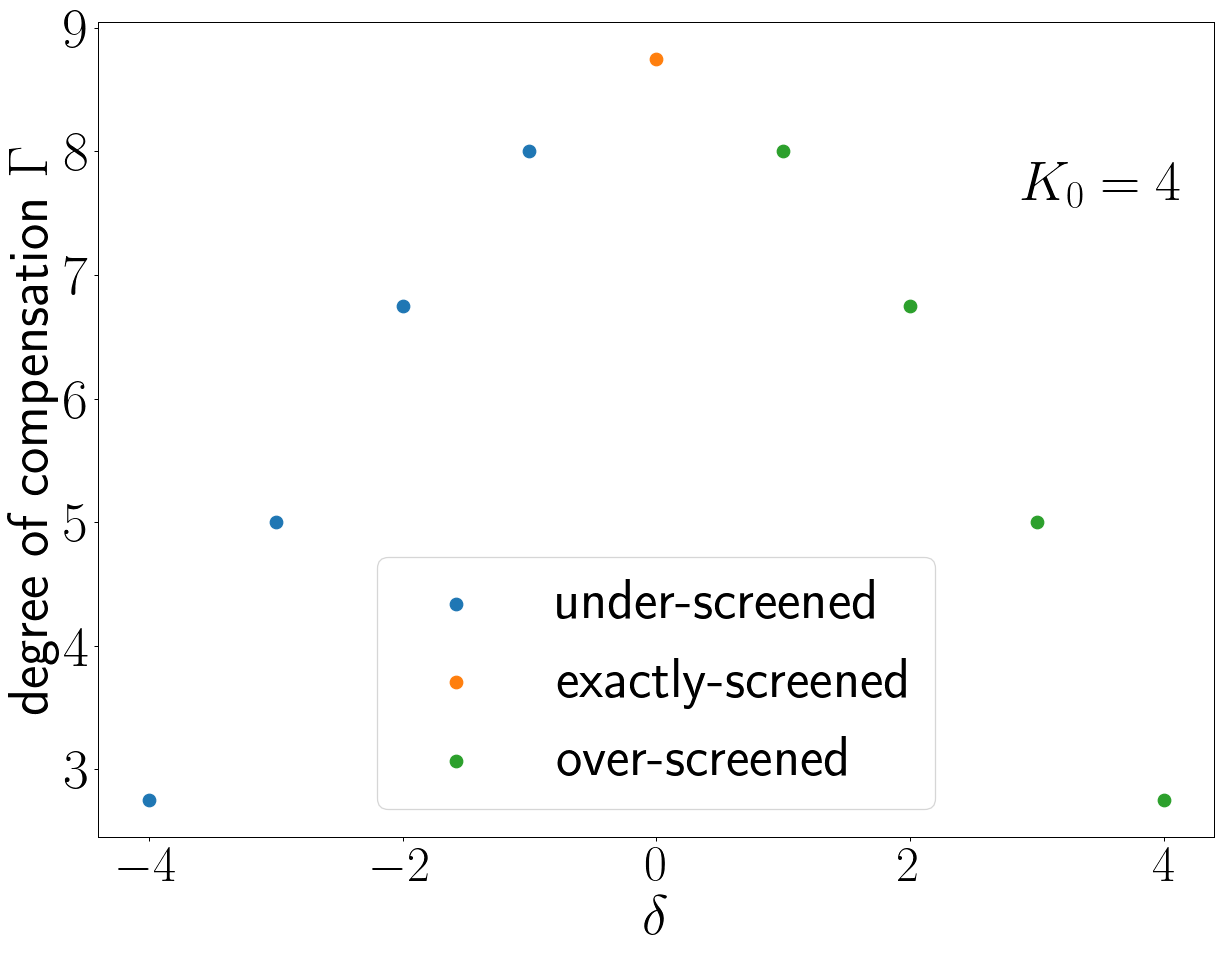

In [97]:
def ham(J,S,K):
    Sx, Sy, Sz = jmat(S)
    sz = sigmaz()/2
    sx = sigmax()/2
    sy = sigmay()/2
    H = 0
    for ch in range(K):
        H += J*tensor([Sx] + [identity(2)]*ch + [sx] + [identity(2)]*(K-ch-1))
        H += J*tensor([Sy] + [identity(2)]*ch + [sy] + [identity(2)]*(K-ch-1))
        H += J*tensor([Sz] + [identity(2)]*ch + [sz] + [identity(2)]*(K-ch-1))
    return H

K_range = np.arange(1, 10, 1)
S_range = np.flip(K_range/2)
K0 = K_range[K_range == 2*S_range][0]
delta = K_range - K0
# print (K_range, 2*S_range)
# gamma = []
# for K,S in zip(K_range, S_range):
#     H = ham(1, S, int(K))
#     E, X = H.eigenstates()
#     gamma.append(-min(E))
gamma = np.array(gamma)
plt.scatter(delta[delta<0], gamma[delta<0], s=100, label=r"under-screened")
plt.scatter(delta[delta==0], gamma[delta==0], s=100, label=r"exactly-screened")
plt.scatter(delta[delta>0], gamma[delta>0], s=100, label=r"over-screened")
plt.xlabel(r"$\delta$")
plt.legend()
plt.ylabel(r"degree of compensation $\Gamma$")
plt.text(0.9, 0.8, r"$K_0 = 4$", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig("deg_of_comp.pdf", bbox_inches="tight")
plt.show()